### Project Info
Mobile carrier Megaline has found out that many of their subscribers use legacy plans. They want to develop a model that would analyze subscribers' behavior and recommend one of Megaline's newer plans: Smart or Ultra. 

You have access to behavior data about subscribers who have already switched to the new plans (from the project for the Statistical Data Analysis course). For this classification task, you need to develop a model that will pick the right plan. Since you’ve already performed the data preprocessing step, you can move straight to creating the model.  

**Develop a model with the highest possible accuracy. In this project, the threshold for accuracy is 0.75. Check the accuracy using the test dataset.**

#### Import all libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import ast
import warnings
import joblib

#### Data Prep

In [3]:
df = pd.read_csv('/datasets/users_behavior.csv')

df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Loaded the data

In [4]:
df.duplicated().sum()

0

In [5]:
df.isnull().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [7]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


- There are no missing values in the dataset and all the columns are the correct data types. 
- The zero values in the features should be left as is.

#### Create data train, validate and test sets

In [8]:
# Define features and target
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']


In [9]:
# Split the data into 60% train, 40% test/validate
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.4, random_state=12345, stratify=target)

# Split the test data into 50% test, 50% validate
features_validate, features_test, target_validate, target_test = train_test_split(features_test, target_test, test_size=0.5, random_state=12345, stratify=target_test)

In [10]:
# Check the shapes
print(f'Features Train: {features_train.shape}')
print(f'Target Train: {target_train.shape}, percent of is_ultra: {target_train.value_counts(normalize=True)[1]:.2f}.')
print(f'Features Validate: {features_validate.shape}')
print(f'Target Validate: {target_validate.shape}, percent of is_ultra: {target_validate.value_counts(normalize=True)[1]:.2f}')
print(f'Features Test: {features_test.shape}')
print(f'Target Test: {target_test.shape}, percent of is_ultra: {target_test.value_counts(normalize=True)[1]:.2f}')

Features Train: (1928, 4)
Target Train: (1928,), percent of is_ultra: 0.31.
Features Validate: (643, 4)
Target Validate: (643,), percent of is_ultra: 0.31
Features Test: (643, 4)
Target Test: (643,), percent of is_ultra: 0.31


**Conclusion**

1) The dataset has been split it into 3 ratios: 60:20:20 for train, valid and test sets respectively.

In [11]:
# Function to plot confusion matrix with score and best parameters
def plot_confusion_matrix_with_score(cm, score, model_name, best_params):
    # Define labels for each quadrant
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)

    # Plot the confusion matrix with labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=True, 
                xticklabels=["Predicted Smart (0)", "Predicted Ultra (1)"],
                yticklabels=["Actual Smart (0)", "Actual Ultra (1)"])
    
    # Add best parameters to the title
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix\nAccuracy: {score:.3f}\nBest Parameters: {best_params}')
    plt.show()


In [12]:
# General model testing function with hyperparameter tuning
def tune_and_test_model(param_grid, model_class, features_train, target_train, features_validate, target_validate, random_state=12345):
    """
    Tune hyperparameters for a machine learning model and test it on validation data.
    """
    # Initialize the model
    model = model_class(random_state=random_state)
    
    # Use GridSearchCV to tune hyperparameters
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    
    # Fit the grid search model on training + validation data
    grid_search.fit(pd.concat([features_train, features_validate]), pd.concat([target_train, target_validate]))
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f'Best parameters for {model_class.__name__}: {best_params}')
    
    # Return the best model and the parameters
    return best_model, best_params


In [13]:
# Function to evaluate the best model on the test data
def evaluate_model_on_test(model, features_test, target_test, best_params):
    """
    Test the best model on the test data and return the test score and confusion matrix.
    """
    # Test the model on the test data
    test_score = model.score(features_test, target_test)
    print(f'{model.__class__.__name__} Test Score: {test_score:.3f}')
    
    # Get predictions for confusion matrix
    predictions = model.predict(features_test)
    
    # Get the confusion matrix
    cm = confusion_matrix(target_test, predictions)
    
    # Plot the confusion matrix with labels, score, and best parameters
    plot_confusion_matrix_with_score(cm, test_score, model.__class__.__name__, best_params)
    
    return test_score

In [14]:
# Define hyperparameter grids for each model
param_grid_tree = {'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10]}
param_grid_forest = {'n_estimators': [100, 200], 'max_depth': [10, 15, 20], 'min_samples_split': [2, 5]}
param_grid_logreg = {'C': [0.01, 0.1, 1, 10], 'solver': ['lbfgs', 'liblinear'], 'max_iter': [100, 500]}

# Tune and test Decision Tree
print("\nTuning and Testing Decision Tree Classifier:")
best_tree_model, best_tree_params = tune_and_test_model(param_grid_tree, DecisionTreeClassifier, features_train, target_train, features_validate, target_validate)

# Tune and test Random Forest
print("\nTuning and Testing Random Forest Classifier:")
best_forest_model, best_forest_params = tune_and_test_model(param_grid_forest, RandomForestClassifier, features_train, target_train, features_validate, target_validate)

# Tune and test Logistic Regression
print("\nTuning and Testing Logistic Regression Classifier:")
best_logreg_model, best_logreg_params = tune_and_test_model(param_grid_logreg, LogisticRegression, features_train, target_train, features_validate, target_validate)



Tuning and Testing Decision Tree Classifier:
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ...................max_depth=5, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=5, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=5, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=5, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=5, min_samples_split=2; total time=   0.0s
[CV] END ...................max_depth=5, min_samples_split=5; total time=   0.0s
[CV] END ...................max_depth=5, min_samples_split=5; total time=   0.0s
[CV] END ...................max_depth=5, min_samples_split=5; total time=   0.0s
[CV] END ...................max_depth=5, min_samples_split=5; total time=   0.0s
[CV] END ...................max_depth=5, min_samples_split=5; total time=   0.0s
[CV] END ..................max_depth=5, min_samples_split=10; total time=   0.0s
[CV

[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=   0.6s
Best parameters for RandomForestClassifier: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

Tuning and Testing Logistic Regression Classifier:
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .................C=0.01, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, max_iter=100, sol


Evaluating the Best Decision Tree on Validation Data:
DecisionTreeClassifier Test Score: 0.826


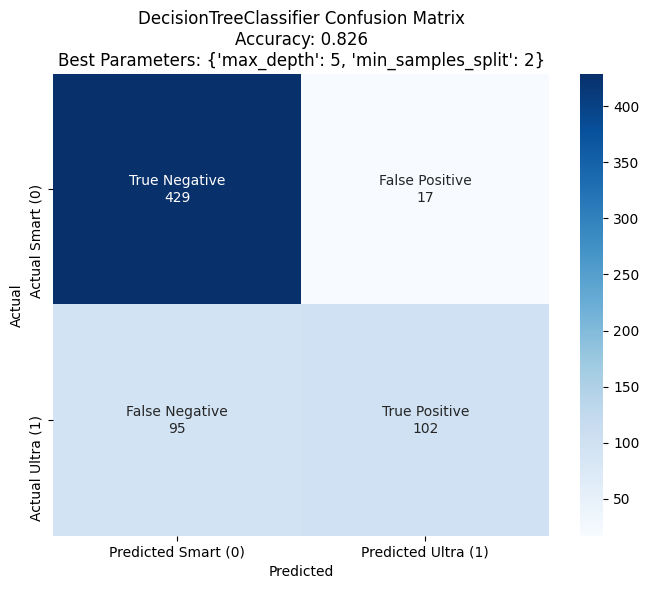

In [15]:
# Evaluate models on the validation set to select the best one
print("\nEvaluating the Best Decision Tree on Validation Data:")
tree_val_score = evaluate_model_on_test(best_tree_model, features_validate, target_validate, best_tree_params)



Evaluating the Best Random Forest on Validation Data:
RandomForestClassifier Test Score: 0.883


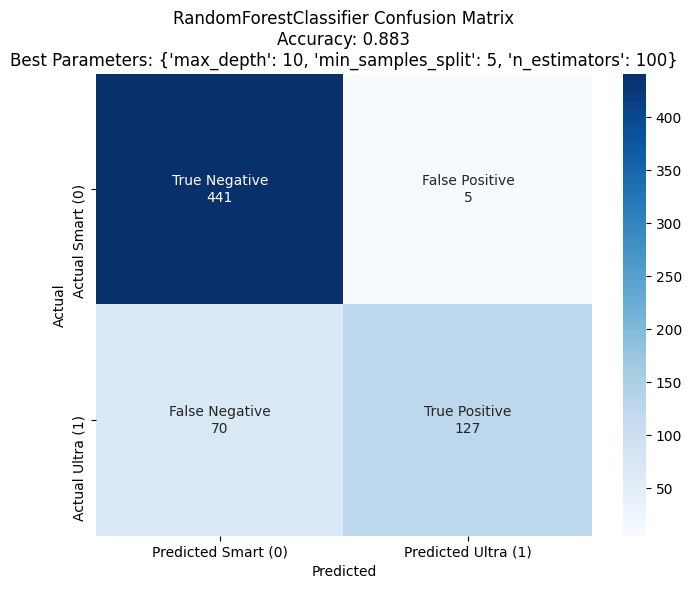

In [16]:
print("\nEvaluating the Best Random Forest on Validation Data:")
forest_val_score = evaluate_model_on_test(best_forest_model, features_validate, target_validate, best_forest_params)




Evaluating the Best Logistic Regression on Validation Data:
LogisticRegression Test Score: 0.742


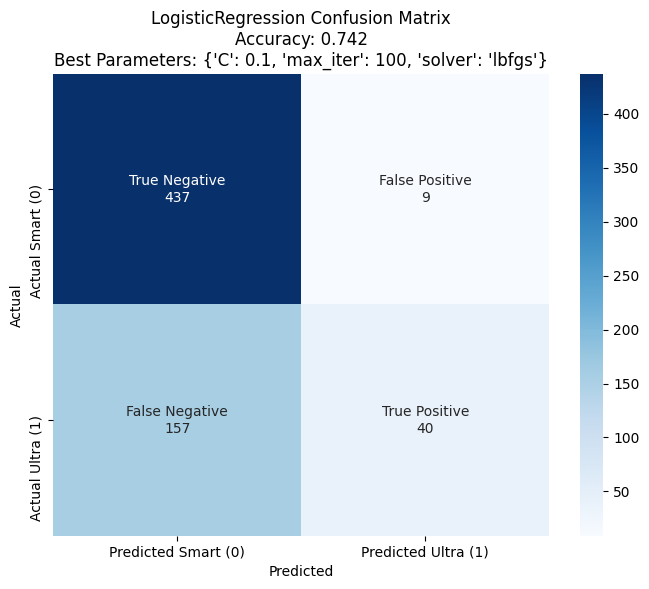

In [17]:
print("\nEvaluating the Best Logistic Regression on Validation Data:")
logreg_val_score = evaluate_model_on_test(best_logreg_model, features_validate, target_validate, best_logreg_params)


#### Best Model is the RandomForrestClassifier


The best model on the validation set is: Random Forest with a validation accuracy of 0.883

Evaluating the selected best model (Random Forest) on the test data:
RandomForestClassifier Test Score: 0.827


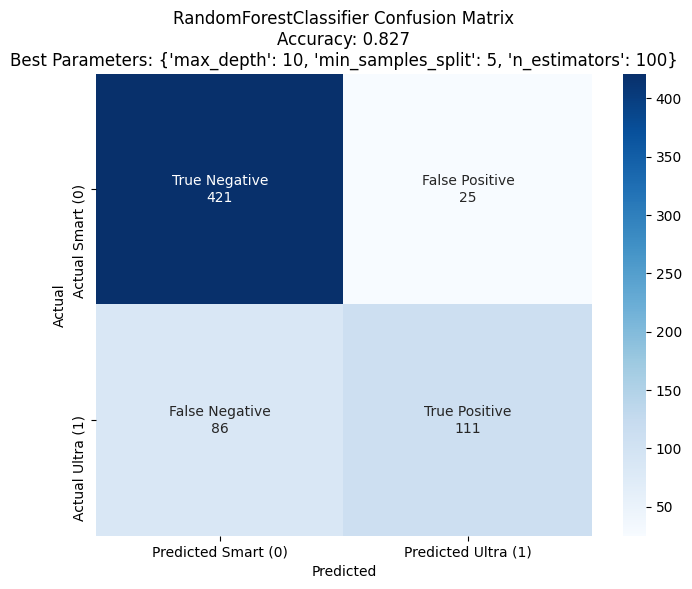


The best model is: Random Forest with a test accuracy of 0.827


In [18]:
# Compare the validation scores and choose the best model based on validation data
model_scores = {
    'Decision Tree': tree_val_score,
    'Random Forest': forest_val_score,
    'Logistic Regression': logreg_val_score
}

# Select the best model based on validation performance
best_model_name = max(model_scores, key=model_scores.get)
best_model_score = model_scores[best_model_name]

# Print the best model from the validation data
print(f"\nThe best model on the validation set is: {best_model_name} with a validation accuracy of {best_model_score:.3f}")

# Evaluate the best model on the test data (only once)
if best_model_name == 'Decision Tree':
    best_model = best_tree_model
    best_params = best_tree_params
elif best_model_name == 'Random Forest':
    best_model = best_forest_model
    best_params = best_forest_params
else:
    best_model = best_logreg_model
    best_params = best_logreg_params

# Evaluate the best model on the test set
print(f"\nEvaluating the selected best model ({best_model_name}) on the test data:")
best_model_test_score = evaluate_model_on_test(best_model, features_test, target_test, best_params)

# Print the final result
print(f"\nThe best model is: {best_model_name} with a test accuracy of {best_model_test_score:.3f}")


- Updated my code to added hyperparameters to all model testing.
- Model are now testing validation data and the best model selected is now testing the test data.

#### Sanity Check

In [21]:
# Check distribution of target variable in train + validate and test sets
print("Training + Validation Target Distribution:")
print(pd.concat([target_train, target_validate]).value_counts(normalize=True))
print("Test Target Distribution:")
print(target_test.value_counts(normalize=True))

# Compare model performance on train + validate vs test set
train_validate_score = best_model.score(pd.concat([features_train, features_validate]), pd.concat([target_train, target_validate]))
print(f'Train + Validate Score: {train_validate_score:.3f}')


Training + Validation Target Distribution:
0    0.693504
1    0.306496
Name: is_ultra, dtype: float64
Test Target Distribution:
0    0.693624
1    0.306376
Name: is_ultra, dtype: float64
Train + Validate Score: 0.876


- The target distributions in the training + validation set and the test set are very similar. This indicates that the class distribution is consistent across these datasets, which is good because it means your model is being tested on data that is representative of the training data.

- The score of 0.876 (or 87.6%) represents the accuracy of your model when evaluated on the combined training and validation dataset.
- This score is relatively high, indicating that the model performs well on the data it was trained and validated on.

In [23]:
predictions = best_model.predict(features_test)

# Generate the classification report
report = classification_report(target_test, predictions, target_names=["Smart (0)", "Ultra (1)"])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

   Smart (0)       0.83      0.94      0.88       446
   Ultra (1)       0.82      0.56      0.67       197

    accuracy                           0.83       643
   macro avg       0.82      0.75      0.78       643
weighted avg       0.83      0.83      0.82       643



#### Observation

- The model performs well for the Smart (0) class with high precision (83%) and recall (94%). This means it's good at identifying Smart users and has a low false negative rate for this class.

- For the Ultra (1) class, the model has lower recall (56%) compared to precision (82%). This indicates that while the model is relatively good at identifying Ultra users when it makes a prediction, it misses a significant portion of them.

- The model achieves an overall accuracy of 83%, which is good. However, the lower recall for Ultra (1) suggests that the model might not be performing as well in identifying all instances of the Ultra class.

### Conclusion

- The best model is the RandomForrestClassifier with an accuracy of 83%.
- Best Param {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5}

In [25]:
joblib.dump(best_model, 'random_forest_model.joblib')

['random_forest_model.joblib']